## Part 1: Introduction to LDA

### Example 1: Riding Mowers

### 🏢 Business Context

A riding mower manufacturer wants to identify which households are likely to purchase their product. They have data on:
- **Income**: Annual household income ($1000s)
- **Lot Size**: Property size (1000s sq ft)
- **Ownership**: Whether they own a riding mower (Yes/No)

**Business objective**: Use income and lot size to predict ownership → target marketing to likely buyers.

### Visualizing the Classification Problem

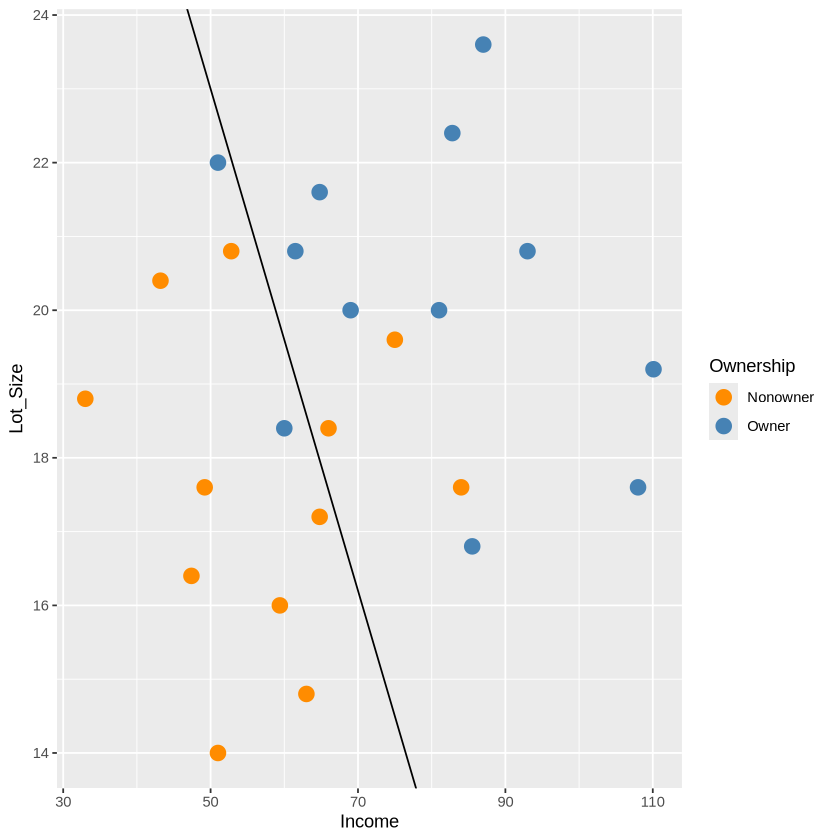

In [2]:
library(ggplot2)
library(mlba)

mowers.df <- mlba::RidingMowers
g <- ggplot(mowers.df, mapping=aes(x=Income, y=Lot_Size, color=Ownership, fill=Ownership)) +
  geom_point(size=4) +
  geom_abline(intercept=40, slope=-0.34) +
  scale_shape_manual(values = c(15, 21)) +
  scale_color_manual(values = c('darkorange', 'steelblue')) +
  scale_fill_manual(values = c('darkorange', 'lightblue'))

g

### 📋 Interpreting the Scatter Plot

**What you see**:
- **Orange points**: Non-owners
- **Blue points**: Owners
- **Diagonal line**: An ad hoc classification boundary

**Pattern**:
- **Lower-left**: Low income + small lot → Non-owners
- **Upper-right**: High income + large lot → Owners

**Business insight**: The two classes are reasonably well-separated. LDA can find the optimal boundary.

### Example 2: Personal Loan Acceptance

### 🏢 Business Context

A bank ran a campaign offering personal loans to liability customers. They want to predict:
- **Who will accept** future loan offers?
- Based on: Income and credit card spending patterns

**Business value**: 
- Target high-probability customers → higher conversion rate
- Avoid wasting resources on unlikely customers → lower cost
- Increase loan portfolio → higher revenue

### Visualizing with Sampling

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


agg_record_2055355247 
                    2

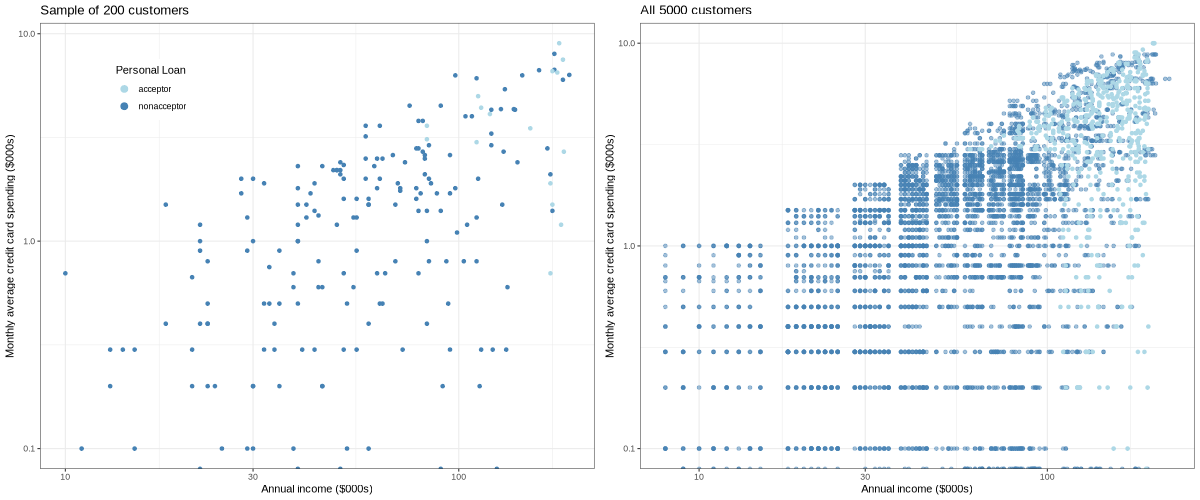

In [6]:
library(gridExtra)
library(tidyverse)
library(IRdisplay)

makePlot  <- function(df, title, alpha) {
  no_personal_loan <- subset(df, Personal.Loan == 0)
  personal_loan <- subset(df, Personal.Loan == 1)

  g <- ggplot(universal.df, aes(x=Income, y=CCAvg, color=Personal.Loan)) +
      geom_point(aes(color="nonacceptor"), data=no_personal_loan, alpha=alpha) +
      geom_point(aes(color="acceptor"), data=personal_loan) +
      labs(title=title, colour="Personal Loan", x='Annual income ($000s)',
           y='Monthly average credit card spending ($000s)') +
      scale_color_manual(values=c("lightblue", "steelblue"),
             guide=guide_legend(override.aes=list(size=3, alpha=1))) +
      scale_x_log10() +
      scale_y_log10() +
      theme_bw()

  return (g)
}

set.seed(1)
universal.df <- mlba::UniversalBank
idx <- sample(dim(universal.df)[1], 200)
g1 <- makePlot(universal.df[idx, ], 'Sample of 200 customers', 1.0) +
        theme(legend.position = c(0.2, 0.85))
g2 <- makePlot(universal.df, 'All 5000 customers', 0.5) +
        guides(color="none")

# Save and display as PNG to avoid text bunching
png("loan_comparison.png", width=1200, height=500)
grid.arrange(g1, g2, ncol=2)
dev.off()
display_png(file="loan_comparison.png")

### 📋 Interpreting the Dual Plot

**Left plot (Sample)**:
- Shows 200 randomly sampled customers
- Easier to see individual points
- Light blue = Non-acceptors (majority)
- Dark blue = Acceptors (minority)

**Right plot (Full data)**:
- All 5000 customers
- Shows overall pattern
- Note: Uses log scale for both axes

**Key observations**:
1. **Class imbalance**: Far more non-acceptors than acceptors
2. **Pattern**: Acceptors tend to cluster in high-income, high-spending region
3. **Separation**: Not perfectly separable, but clear tendency

**Business challenge**: With severe class imbalance, model might predict "non-acceptor" for everyone and still be 90%+ accurate but useless!

---

## Part 2: Fisher's Linear Classification Functions

### 🏢 Business Context: How LDA Makes Decisions

LDA computes a **classification score** for each class. The observation is assigned to the class with the **highest score**.

**Fisher's classification function**:
```
Score(class) = c₀ + c₁×Feature₁ + c₂×Feature₂ + ...
```

Each class gets its own function. Compare scores → pick winner.

### Building the LDA Model (caret approach)

In [7]:
library(caret)
mowers.df <- mlba::RidingMowers
trControl <- caret::trainControl(method='none')
model <- train(Ownership ~ Income + Lot_Size, data=mowers.df,
               method='lda', trControl=trControl)
model$finalModel  # access the wrapped LDA model

Call:
lda(x, grouping = y)

Prior probabilities of groups:
Nonowner    Owner 
     0.5      0.5 

Group means:
         Income Lot_Size
Nonowner 57.400 17.63333
Owner    79.475 20.26667

Coefficients of linear discriminants:
               LD1
Income   0.0484468
Lot_Size 0.3795228

### 📋 Understanding the Model Output

**Key components**:
- **Prior probabilities**: Proportion of each class in training data
- **Group means**: Average Income and Lot_Size for each class
- **Coefficients of linear discriminants**: How features combine to separate classes

**Business interpretation**: 
- If a household's Income/Lot_Size are closer to "Owner" group means → Higher probability of ownership

### Extracting Fisher's Functions (DiscriMiner package)

In [9]:
# DiscriMiner exposes the Fisher's linear classification function
library(DiscriMiner)
mowers.df <- mlba::RidingMowers
da.mower <- linDA(mowers.df[,1:2], mowers.df[,3])
da.mower$functions

Registered S3 method overwritten by 'DiscriMiner':
  method      from 
  print.plsda caret



,Nonowner,Owner
constant,-51.4214500,-73.1602116
Income,0.3293554,0.4295857
Lot_Size,4.6815655,5.4667502


### 📋 Interpreting Fisher's Functions

**Each column** is a classification function for one class:

```
Score(Nonowner) = c₀ + c₁×Income + c₂×Lot_Size
Score(Owner)    = d₀ + d₁×Income + d₂×Lot_Size
```

**Classification rule**: If Score(Owner) > Score(Nonowner) → Predict "Owner"

**Coefficients interpretation**:
- Larger coefficient = Feature has more impact on that class's score
- Sign indicates direction (positive = increases score)

### Computing Propensities Manually

In [10]:
da.mower <- linDA(mowers.df[,1:2], mowers.df[,3])
# compute propensities manually (below); or, use lda() in package MASS or caret with predict()
propensity.owner <- exp(da.mower$scores[,2])/(exp(da.mower$scores[,1])+exp(da.mower$scores[,2]))
data.frame(Actual=mowers.df$Ownership, Predicted=da.mower$classification,
           da.mower$scores, propensity.owner=propensity.owner)

,Actual,Predicted,Nonowner,Owner,propensity.owner
,<chr>,<fct>,<dbl>,<dbl>,<dbl>
1,Owner,Nonowner,54.48068,53.20314,0.217968446
2,Owner,Owner,55.38874,55.41077,0.505507885
3,Owner,Owner,71.04260,72.75875,0.847632493
4,Owner,Owner,66.21047,66.96771,0.680755073
5,Owner,Owner,87.71742,93.22905,0.995976750
6,Owner,Owner,74.72664,79.09878,0.987533203
7,Owner,Owner,66.54449,69.44985,0.948110866
8,Owner,Owner,80.71625,84.86469,0.984456467
9,Owner,Owner,64.93538,65.81621,0.706992840


### 📋 Understanding Propensities (Probabilities)

**Columns explained**:
- **Actual**: True class from data
- **Predicted**: LDA's classification
- **Nonowner/Owner** (scores): Raw Fisher scores for each class
- **propensity.owner**: Probability of being an owner (0 to 1)

**Business use of propensities**:

| Propensity Range | Interpretation | Marketing Action |
|------------------|----------------|------------------|
| **0.9 - 1.0** | Very likely owner | Premium marketing, direct sales call |
| **0.7 - 0.9** | Probable owner | Targeted email campaign |
| **0.3 - 0.7** | Uncertain | Collect more data, nurture lead |
| **0.0 - 0.3** | Unlikely owner | Minimal/no marketing effort |

### Visualizing the LDA Classification Boundary

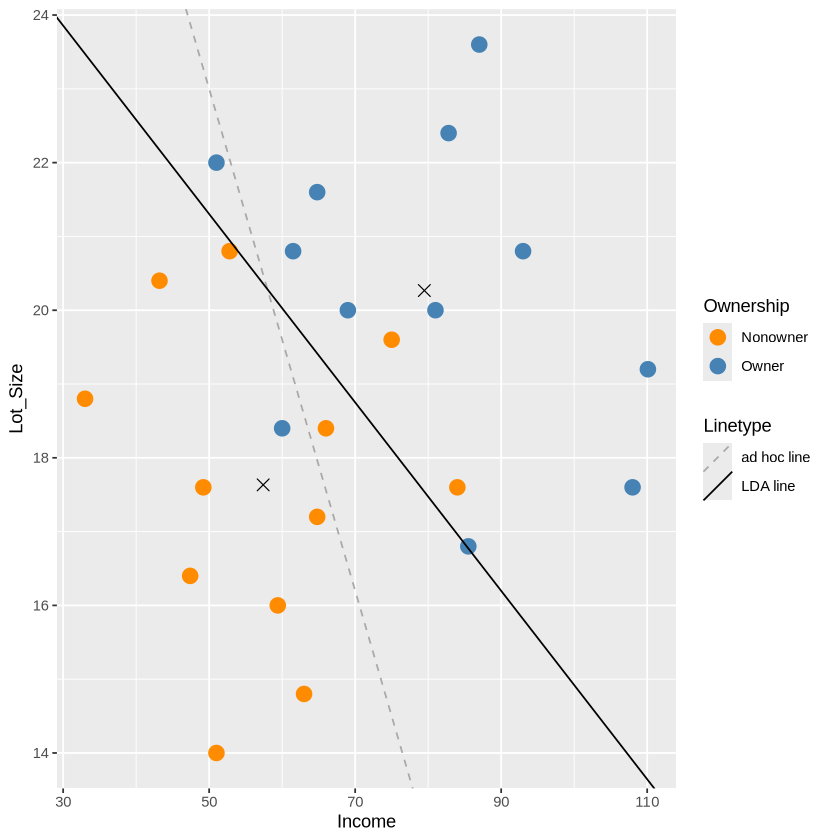

In [11]:
library(ggplot2)
da.mower <- train(Ownership ~ Income + Lot_Size, data=mowers.df,
                  method='lda', trControl=trControl)
means <- colSums(da.mower$finalModel$means) / 2
sIncome <- da.mower$finalModel$scaling['Income', 'LD1']
sLotSize <- da.mower$finalModel$scaling['Lot_Size', 'LD1']
m <- - sIncome / sLotSize
y0 <- means['Lot_Size'] - m * means['Income']

mowers.df <- mlba::RidingMowers
g <- ggplot(mowers.df, mapping=aes(x=Income, y=Lot_Size, color=Ownership, fill=Ownership)) +
  geom_point(size=4) +
  geom_point(data=data.frame(da.mower$finalModel$means), color='black', fill='black', shape=4, size=3) +
  geom_abline(aes(linetype='ad hoc line', intercept=40, slope=-0.34), color='darkgrey') +
  geom_abline(aes(linetype='LDA line', intercept=y0, slope=m)) +
  scale_shape_manual(values = c(15, 21)) +
  scale_color_manual(values = c('darkorange', 'steelblue')) +
  scale_fill_manual(values = c('darkorange', 'lightblue')) +
  scale_linetype_manual(name='Linetype', values=c(2, 1), labels=c('ad hoc line', 'LDA line')) +
  guides(fill = guide_legend(order = 1), color = guide_legend(order = 1), 
         linetype = guide_legend(order = 2))
g

### 📋 Interpreting the LDA Boundary

**Elements in the plot**:
- **Orange/Blue points**: Actual data (non-owners/owners)
- **Black X marks**: Class centroids (group means)
- **Dashed grey line**: Ad hoc boundary (manual guess)
- **Solid black line**: LDA boundary (statistically optimal)

**How to read it**:
- Points **above** LDA line → Predicted as "Owner"
- Points **below** LDA line → Predicted as "Nonowner"
- LDA line passes between the two centroids

**Business insight**: 
- LDA finds the optimal linear separator based on the data
- It's data-driven, not arbitrary like the ad hoc line
- Misclassifications still occur near the boundary (inherent uncertainty)

---

## Part 3: Prior Probabilities

### 🏢 Business Context: Adjusting for Class Imbalance

By default, LDA uses **sample proportions** as prior probabilities. But what if:
- Your sample has 50/50 owners vs. non-owners
- But in reality, only 15% of population are owners

**Problem**: Model will over-predict "Owner" because it learned from unrepresentative data.

**Solution**: Specify **prior probabilities** that match the real-world population.

### Example: Adjusting Priors

In [12]:
trControl <- caret::trainControl(method='none')
model <- train(Ownership ~ Income + Lot_Size, data=mowers.df,
               method='lda', trControl=trControl)
model.prior <- train(Ownership ~ Income + Lot_Size, data=mowers.df,
               method='lda', prior=c(0.85, 0.15),
               trControl=trControl)

family.13 <- mowers.df[13,]
predict(model, family.13)
predict(model.prior, family.13)

[1] Owner
Levels: Nonowner Owner

[1] Nonowner
Levels: Nonowner Owner

### 📋 Interpreting Prior Probability Impact

**What happened**:
- **Default model** (equal priors): Predicts based on sample proportions
- **Adjusted model** (0.85 non-owner, 0.15 owner): Reflects real-world rarity

**For family #13**:
- Default model might predict "Owner"
- Adjusted model might predict "Nonowner" (because owners are rare)

### 🏢 When to Adjust Priors

| Scenario | Sample Proportion | Real-World Proportion | Action |
|----------|-------------------|----------------------|--------|
| **Fraud detection** | 50/50 (balanced sample) | 0.1% fraud | Set prior = [0.999, 0.001] |
| **Disease diagnosis** | 30% positive (enriched) | 5% population | Set prior = [0.95, 0.05] |
| **Loan default** | 20% default (sample) | 3% default | Set prior = [0.97, 0.03] |

**Business impact**:
- **Without adjustment**: Over-predict rare class → wasted resources
- **With adjustment**: Realistic predictions → better ROI

---

## Part 4: Classifying More Than Two Classes

### 🏢 Business Context: Multi-Class Problems

Many business problems have **more than two outcomes**:

| Industry | Classification Problem | Classes |
|----------|------------------------|----------|
| **Healthcare** | Emergency severity | No injury / Injury / Fatality |
| **Retail** | Customer value | Low / Medium / High |
| **Credit** | Risk category | Low / Medium / High / Very High |
| **Manufacturing** | Defect type | None / Minor / Major / Critical |

LDA handles multi-class naturally — same approach, more classification functions.

### Example 3: Medical Dispatch to Accident Scenes

### 🏢 Business Context

When an accident is reported, emergency dispatchers must decide:
- Send basic medical response?
- Send advanced life support?
- Full trauma team?

**Data**: Past accidents with variables like weather, road type, time of day, number of vehicles
**Target**: MAX_SEV (maximum injury severity)
- **0**: No injury
- **1**: Injury
- **2**: Fatality

**Business value**: 
- Faster response to serious cases → lives saved
- Appropriate resource allocation → cost efficiency
- Reduced under/over-response → better outcomes

### Building Multi-Class LDA (DiscriMiner approach)

In [13]:
library(DiscriMiner)
library(caret)

accidents.df <-  mlba::Accidents
lda.model <- linDA(accidents.df[,1:10], accidents.df[,11])
lda.model$functions

,fatal,no-injury,non-fatal
constant,-25.5958096,-24.5143230,-24.2336222
RushHour,0.9225624,1.9524034,1.9031992
WRK_ZONE,0.5178609,1.1950603,0.7705682
WKDY,4.7801494,6.4176338,6.1165224
INT_HWY,-1.8418783,-2.6730379,-2.5366225
LGTCON_day,3.7070124,3.6660756,3.7276208
LEVEL,2.6268938,1.5675507,1.7138657
SPD_LIM,0.5051317,0.4614797,0.4520848
SUR_COND_dry,9.9988601,15.8337945,16.2565640
TRAF_two_way,7.1079766,6.3421473,6.3549435


### 📋 Understanding Multi-Class Functions

**Now we have 3 classification functions** (one per severity level):

```
Score(No injury) = f₀(features)
Score(Injury)    = f₁(features)
Score(Fatality)  = f₂(features)
```

**Classification rule**: Assign to class with **highest score**

**Coefficients interpretation**:
- Each variable contributes to each severity score
- Compare coefficients across classes to see which features matter for each severity

### Confusion Matrix for Multi-Class

In [14]:
confusionMatrix(as.factor(lda.model$classification), as.factor(accidents.df$MAX_SEV))

Confusion Matrix and Statistics

           Reference
Prediction  fatal no-injury non-fatal
  fatal         1         6         6
  no-injury     1       114        95
  non-fatal     3       172       202

Overall Statistics
                                          
               Accuracy : 0.5283          
                 95% CI : (0.4875, 0.5689)
    No Information Rate : 0.505           
    P-Value [Acc > NIR] : 0.1351          
                                          
                  Kappa : 0.0791          
                                          
 Mcnemar's Test P-Value : 6.555e-06       

Statistics by Class:

                     Class: fatal Class: no-injury Class: non-fatal
Sensitivity              0.200000           0.3904           0.6667
Specificity              0.979832           0.6883           0.4108
Pos Pred Value           0.076923           0.5429           0.5358
Neg Pred Value           0.993186           0.5436           0.5471
Prevalence              

### 📋 Reading the Confusion Matrix

**Structure** (3×3 matrix for 3 classes):

```
               Predicted
            0      1      2
Actual  0  [ ]    [ ]    [ ]
        1  [ ]    [ ]    [ ]
        2  [ ]    [ ]    [ ]
```

**How to interpret**:
- **Diagonal** (top-left to bottom-right): **Correct predictions**
- **Off-diagonal**: **Misclassifications**

**Key metrics**:
- **Overall Accuracy**: % of correct predictions
- **Per-class sensitivity**: % of actual class X correctly identified
- **Per-class precision**: % of predicted class X that were correct

### 🏢 Business Implications of Misclassification

Not all errors are equal:

| Error Type | Example | Business Cost |
|------------|---------|---------------|
| **Fatality predicted as No injury** | Send basic response to fatal crash | **VERY HIGH** - lives at risk |
| **No injury predicted as Fatality** | Send full team to minor accident | **MEDIUM** - wasted resources |
| **Injury vs. Fatality confusion** | Wrong level of response | **HIGH** - inadequate care |

**Action**: Weight errors differently in model evaluation or use cost-sensitive learning.

### Propensities for Multi-Class

In [15]:
propensity <- exp(lda.model$scores[,1:3])/
    (exp(lda.model$scores[,1])+exp(lda.model$scores[,2])+exp(lda.model$scores[,3]))

res <- data.frame(Actual = accidents.df$MAX_SEV,
           Classification = lda.model$classification,
           Score = round(lda.model$scores,2),
           Propensity = round(propensity,2))
head(res)

,Actual,Classification,Score.fatal,Score.no.injury,Score.non.fatal,Propensity.fatal,Propensity.no.injury,Propensity.non.fatal
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,no-injury,no-injury,25.94,31.42,30.93,0.00,0.62,0.38
2,non-fatal,no-injury,15.00,15.58,15.01,0.26,0.47,0.27
3,no-injury,no-injury,2.69,9.95,9.81,0.00,0.54,0.46
4,no-injury,no-injury,10.10,17.94,17.64,0.00,0.57,0.43
5,non-fatal,no-injury,2.42,11.76,11.41,0.00,0.59,0.41
6,non-fatal,no-injury,7.47,16.37,15.93,0.00,0.61,0.39


### 📋 Understanding Multi-Class Propensities

**Columns explained**:
- **Actual**: True severity from data
- **Classification**: LDA's predicted severity
- **Score.X**: Raw Fisher scores for each class (0, 1, 2)
- **Propensity.X**: Probability for each class (sum to 1)

**Business use**:

| Propensity Pattern | Interpretation | Dispatch Decision |
|--------------------|----------------|-------------------|
| **[0.9, 0.08, 0.02]** | Very likely no injury | Basic response |
| **[0.3, 0.6, 0.1]** | Probably injury | Advanced response |
| **[0.1, 0.2, 0.7]** | Likely fatality | **Full trauma team** |
| **[0.33, 0.33, 0.34]** | **Uncertain!** | Err on side of caution → send advanced |

### Tidyverse Approach (Cleaner Code)

In [16]:
library(tidyverse)
accidents.df <-  mlba::Accidents %>%
  mutate(MAX_SEV = factor(MAX_SEV))
da.model <- train(MAX_SEV ~ ., data=accidents.df, method='lda')
res <- data.frame(Actual=accidents.df$MAX_SEV,
           Classification=predict(da.model),
           Propensity=predict(da.model, type='prob') %>% round(2))
head(res)

,Actual,Classification,Propensity.fatal,Propensity.no.injury,Propensity.non.fatal
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,no-injury,no-injury,0.00,0.62,0.38
2,non-fatal,no-injury,0.26,0.47,0.27
3,no-injury,no-injury,0.00,0.54,0.46
4,no-injury,no-injury,0.00,0.57,0.43
5,non-fatal,no-injury,0.00,0.59,0.41
6,non-fatal,no-injury,0.00,0.61,0.39


### 📋 Caret vs. DiscriMiner

**DiscriMiner**:
- Exposes Fisher's classification functions directly
- Good for understanding the math
- Manual propensity calculation

**Caret** (recommended):
- Consistent interface across many ML methods
- Built-in `predict()` with `type='prob'` for propensities
- Easy to switch between algorithms (lda → qda → rf)
- Better for production pipelines

---

## Summary: Key Takeaways

### 🔧 Essential Functions Reference

#### Building LDA Models
| Task | Function | Notes |
|------|----------|-------|
| LDA with caret | `train(y ~ ., data, method='lda')` | Recommended approach |
| LDA with DiscriMiner | `linDA(X, y)` | Exposes Fisher functions |
| Set priors | `train(..., prior=c(0.85, 0.15))` | Adjust for class imbalance |

#### Making Predictions
| Task | Function | Output |
|------|----------|--------|
| Predict class | `predict(model, newdata)` | Predicted class labels |
| Predict probabilities | `predict(model, newdata, type='prob')` | Propensity scores |
| Confusion matrix | `confusionMatrix(pred, actual)` | Performance metrics |

---

### 🎯 LDA Best Practices Checklist

✅ **Check assumptions**:
   - Features normally distributed within classes?
   - Equal covariance matrices?
   - If violated, consider QDA or other methods

✅ **Handle class imbalance**:
   - Set priors to match real-world proportions
   - Or use resampling (upsampling/downsampling)

✅ **Scale features** if on different units

✅ **Use propensities** for:
   - Ranking customers (top 10% most likely buyers)
   - Cost-sensitive decisions (weight by business impact)
   - Uncertainty assessment (low max propensity = uncertain)

✅ **Evaluate on holdout set**
   - Never trust training performance alone
   - Use confusion matrix to check all error types

✅ **Consider business costs**
   - False positive vs. false negative costs differ
   - Adjust decision threshold accordingly

---

### 🏢 Business Value Summary

| LDA Component | Business Use | Example |
|---------------|--------------|----------|
| **Classification** | Segment customers, prioritize cases | Loan marketing, emergency dispatch |
| **Propensities** | Rank by likelihood, optimize targeting | Top 20% prospects, resource allocation |
| **Prior adjustment** | Reflect real-world rarity | Fraud (0.1%), disease (5%) |
| **Multi-class** | Granular decisions | Low/Medium/High risk categories |
| **Boundary visualization** | Explain to stakeholders | "Here's how we decide" |

---

### 📊 LDA vs. Other Methods

**When to use LDA**:
- ✅ Classes reasonably well-separated
- ✅ Features approximately normal
- ✅ Need interpretable linear boundary
- ✅ Want fast training/prediction
- ✅ Multi-class problems

**When to consider alternatives**:
- ❌ Non-linear boundaries → Try QDA, SVM, Random Forest
- ❌ Very different covariances → Try QDA
- ❌ High-dimensional data → Try regularized methods
- ❌ Heavily imbalanced → Try cost-sensitive learning

---

### 📚 Connection to Other Modules

- **Module 1.1**: Use train/test splits for LDA validation
- **Module 2.2**: PCA → LDA (dimension reduction before classification)
- **Module 3**: Compare LDA to PCR for supervised dimension reduction
- **Module 5**: Clustering → LDA (unsupervised → supervised)

---

**Next Steps**: 
1. Apply LDA to your own classification problems
2. Always set priors based on real-world proportions
3. Use propensities for business decisions, not just hard classifications
4. Evaluate using appropriate metrics for your business context!